In [1]:
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
# import input_data
mnist = input_data.read_data_sets("../data/MNIST", one_hot=True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow as tf

In [3]:
# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

In [4]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [5]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

R = tf.Variable("float", [None, n_input])

In [6]:
def _simple_lrp(R, X, W, b):
    Z = tf.expand_dims(W, 0) * tf.expand_dims(X, -1)
    Zs = tf.add(tf.expand_dims(tf.reduce_sum(Z, 1), 1),
                tf.expand_dims(tf.expand_dims(b, 0), 0))
    return tf.reduce_sum(
            (Z / Zs) * tf.expand_dims(R, 1),
            2)

In [7]:
# relevance propagation
def relevance_propagation(y_pred, 
                          reversed_layers_inputs,
                          reversed_layers_weights,
                          reversed_layers_biases):
    assert len(reversed_layers_inputs) == len(reversed_layers_weights) == len(reversed_layers_biases)
    R = y_pred
    for i in range(len(reversed_layers_inputs)):
        R = _simple_lrp(R, 
                        reversed_layers_inputs[i],
                        reversed_layers_weights[i],
                        reversed_layers_biases[i])
    return R

In [8]:
# Create model
def multilayer_perceptron_lrp(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1_activations = tf.nn.tanh(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1_activations, weights['h2']), biases['b2'])
    layer_2_activations = tf.nn.tanh(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2_activations, weights['out']) + biases['out']
    
    R = relevance_propagation(out_layer, 
                              [layer_2_activations, layer_1_activations, x],
                              [weights['out'], weights['h2'], weights['h1']],
                              [biases['out'], biases['b2'], biases['b1']])
    
    return out_layer, R

In [9]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [10]:
# Construct model
pred, R = multilayer_perceptron_lrp(x, weights, biases)

In [11]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [12]:
# Initializing the variables
init = tf.initialize_all_variables()

In [13]:
saver = tf.train.Saver()

In [14]:
model_path = "model.ckpt"

In [15]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print ("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Accuracy: {}".format(accuracy.eval({x: mnist.test.images, y: mnist.test.labels})))
    
    saver.save(sess, model_path)

Epoch: 0001 cost= 6.688744279
Epoch: 0002 cost= 2.491919826
Epoch: 0003 cost= 1.679120137
Epoch: 0004 cost= 1.224639658
Epoch: 0005 cost= 0.907718809
Epoch: 0006 cost= 0.696063237
Epoch: 0007 cost= 0.540805862
Epoch: 0008 cost= 0.422097471
Epoch: 0009 cost= 0.329363246
Epoch: 0010 cost= 0.255429530
Epoch: 0011 cost= 0.202367658
Epoch: 0012 cost= 0.174606755
Epoch: 0013 cost= 0.147124677
Epoch: 0014 cost= 0.122132774
Epoch: 0015 cost= 0.106500016
Optimization Finished!
Accuracy: 0.8809000253677368


In [16]:
# import matplotlib.pyplot as plt
# %matplotlib inline

In [17]:
# plt.imshow(mnist.test.images[0].reshape(28, 28), cmap=plt.cm.binary)

In [18]:
with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, model_path)
    predictions = sess.run(pred, feed_dict={x: mnist.test.images[:1]})
    print (predictions.shape)
    print (predictions)

(1, 10)
[[ -5.19088411 -13.56048679  22.07215118  12.98138237 -21.61441803
   -2.89621425 -16.432724    47.64886093 -17.41369057  -1.14940417]]


In [19]:
with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, model_path)
    relevance = sess.run(R, feed_dict={x: mnist.test.images[:1]})
    print (relevance.shape)
    print (relevance)

(1, 784)
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000

In [20]:
# import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
import sys
sys.path.append("../python")

In [22]:
import render
import data_io

saving image to ./heatmap.png
writing data in npy-format to /home/scitator/Documents/Git/lrp_toolbox/tensorflow/heatmap.npy


/opt/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
/opt/anaconda/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


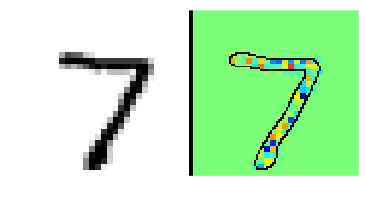

In [23]:
test_x = mnist.test.images[:1]
digit = render.digit_to_rgb(test_x, scaling = 3)
hm = render.hm_to_rgb(relevance, X = test_x, scaling = 3, sigma = 2)
digit_hm = render.save_image([digit,hm],'./heatmap.png')
data_io.write(relevance,'./heatmap.npy')

#display the image as written to file
plt.imshow(digit_hm, interpolation = 'none', cmap=plt.cm.binary)
plt.axis('off')
plt.show()

In [9]:
import numpy as np

In [10]:
np.max(mnist.test.images[0])

1.0

In [11]:
np.min(mnist.test.images[0])

0.0

In [6]:
mnist.test.labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])